<a href="https://colab.research.google.com/github/aleruriphd/anz-container-day-sample-api-service-go/blob/master/autoencoders_anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
dataset = pd.read_csv("EngineFaultDB_Final.csv")
dataset.head()

,Fault,MAP,TPS,Force,Power,RPM,Consumption L/H,Consumption L/100KM,Speed,CO,HC,CO2,O2,Lambda,AFR
0,0,3.549,1.889,7.428,5.227,1192.769,3.057,11.720,24.901,0.460,196.089,14.356,1.080,1.047,15.385
1,0,3.559,1.899,7.646,5.327,1145.191,2.914,11.276,25.030,0.478,196.283,14.492,1.107,1.083,15.926
2,0,3.539,1.899,7.578,5.100,1208.505,2.976,11.926,24.213,0.464,200.367,14.443,1.099,1.072,15.754
3,0,3.519,1.889,7.371,5.255,1164.127,2.908,11.786,24.407,0.471,195.345,13.853,1.076,1.006,14.787
4,0,3.549,1.879,7.405,5.177,1172.032,2.898,12.169,24.875,0.468,194.979,13.752,1.060,0.984,14.470


In [5]:
dataset["Fault"].unique()

array([0, 1, 2, 3])

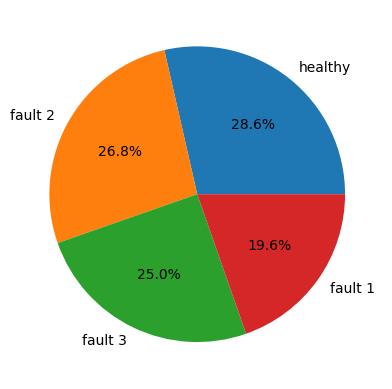

In [6]:
count = dataset['Fault'].value_counts()
plt.pie(x=count.values, labels=['healthy', 'fault 2', 'fault 3', 'fault 1'], autopct='%1.1f%%')
plt.show()

In [7]:
count

,count
Fault,
0,16000
2,15000
3,14001
1,10998


In [8]:
#check for null values

dataset.isnull().sum()

,0
Fault,0
MAP,0
TPS,0
Force,0
Power,0
RPM,0
Consumption L/H,0
Consumption L/100KM,0
Speed,0
CO,0


In [9]:
#statistical description
dataset.describe()

,Fault,MAP,TPS,Force,Power,RPM,Consumption L/H,Consumption L/100KM,Speed,CO,HC,CO2,O2,Lambda,AFR
count,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000
mean,1.482187,1.832515,1.395269,286.691705,5.657126,2398.053774,4.497634,8.939794,51.688740,1.932430,188.446083,13.035230,0.585910,0.963907,14.169408
std,1.149430,0.837786,0.906950,378.774917,7.684147,932.008680,2.221497,3.154110,20.140345,1.988789,111.047015,1.046567,0.223713,0.065973,0.969802
min,0.000000,0.453000,0.382000,2.580000,0.465000,1066.452000,1.917000,5.187000,22.757000,0.421000,1.787000,8.649000,0.203000,0.695000,10.210000
25%,0.000000,1.217000,0.901000,76.848500,0.994000,1830.200500,2.981000,6.573000,39.412000,0.641000,158.803000,12.842000,0.415000,0.937000,13.780000
50%,2.000000,1.543000,1.013000,92.500000,2.398000,2105.588000,3.824000,8.068000,45.393000,1.129000,178.265000,13.242000,0.533000,0.977000,14.365000
75%,3.000000,1.940000,1.258000,257.989500,4.696000,2761.373500,5.144500,9.924000,59.508000,2.455000,203.678000,13.639000,0.789000,1.008000,14.823000
max,3.000000,4.547000,4.048000,1537.118000,33.946000,5013.402000,14.810000,20.043000,107.539000,10.132000,975.657000,15.129000,1.151000,1.149000,16.893000


In [14]:
#create the healthy dataset
healthy_dataset = dataset[dataset['Fault'] == 0]

In [15]:
healthy_dataset.shape

(16000, 15)

In [16]:
#Doublecheck if there are only healthy data within the healthy dataset:
healthy_dataset["Fault"].unique()

array([0])

In [17]:
#Remove the "fault" column as we don't need it to understand the behaviour of the data
healthy_dataset = healthy_dataset.drop("Fault", axis=1)

In [18]:
healthy_dataset.shape

(16000, 14)

In [19]:
#This is the feature vector that goes to the neural net
healthy_input = healthy_dataset.values

**2.2 Train and Test Split**
First, generate the train and test split. Then, normalise the training data. Afterwards, perform normalisation on testing samples as well, but this time using the mean and variance of training variables. In this way, we can test and evaluate whether our model can generalise well to new, unseen data points.

In [21]:
from sklearn.model_selection import train_test_split

healthy_train, healthy_test =  train_test_split(healthy_input, test_size=0.2, random_state=42)

print(f"Good train count: {len(healthy_train)}")
print(f"Good test count: {len(healthy_test)}")

Good train count: 12800
Good test count: 3200


It is good practice to normalise input data to the model. This can assist your NN to learn faster

In [23]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

#Configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

pipeline.fit(healthy_train);

In [24]:
#Transform the training and validatation data with these parameters
train_transformed = pipeline.transform(healthy_train)
test_transformed = pipeline.transform(healthy_test)

**3. Model Engineering and Training**

**3.1 Model Engineering**

In [25]:
#This is the size of the features (columns)
input_dimension=train_transformed.shape[1]

In [28]:
#Define the autoencoder model
#Since we are dealing with numeric values we can use only Dense layers

from sklearn import metrics
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(10, input_dim = input_dimension, activation='relu')) #input dimensions equal to number of features(columns)
model.add(Dense(3, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(input_dimension)) #Output dimensions equal to number of features(columns) as we reconstruct the data

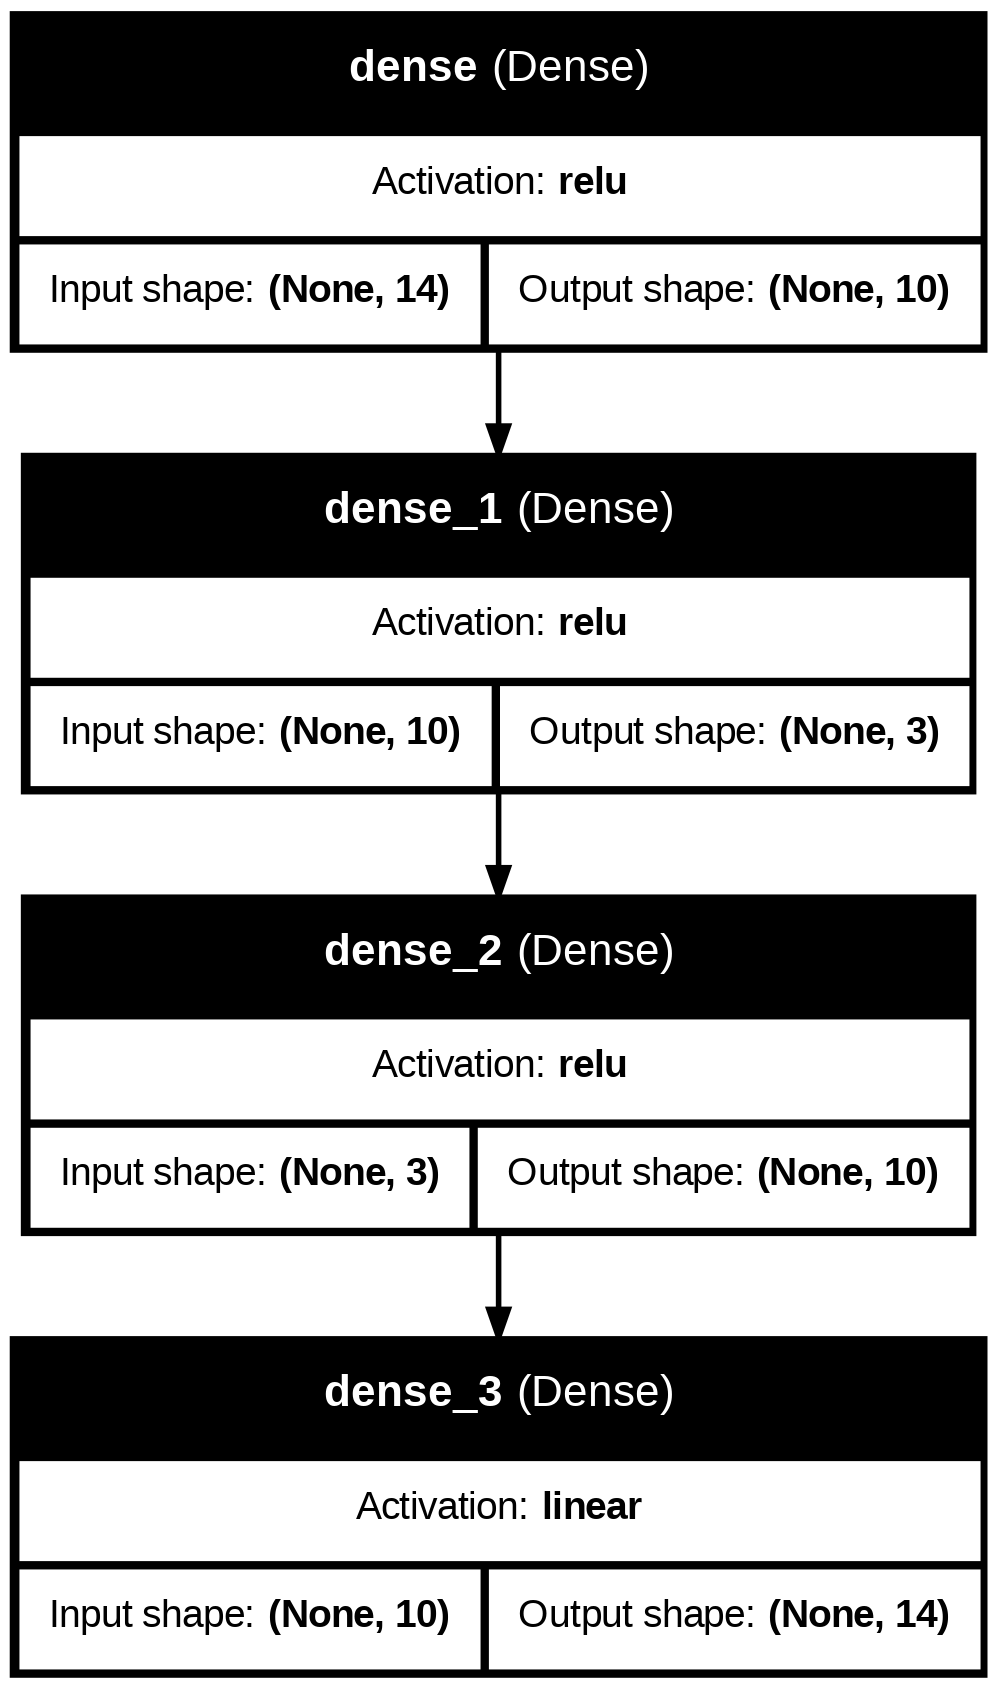

In [29]:
import tensorflow as tf
tf.keras.utils.plot_model(model, rankdir="TB", show_shapes=True, show_layer_activations=True, show_layer_names=True)

In [31]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │           154 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 377 (1.47 KB)

 Trainable params: 377 (1.47 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
BATCH_SIZE = 1026
EPOCHS = 200
history = model.fit(train_transformed, train_transformed, verbose=1, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(test_transformed, test_transformed))

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.2667 - val_loss: 0.2404
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2340 - val_loss: 0.2155
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2089 - val_loss: 0.1906
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1850 - val_loss: 0.1678
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1624 - val_loss: 0.1468
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1420 - val_loss: 0.1279
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1237 - val_loss: 0.1114
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1072 - val_loss: 0.0976
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0945 - val_loss: 0.0865
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0844 - val_loss: 0.0778
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0759 - val_loss: 0.0713
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - lo

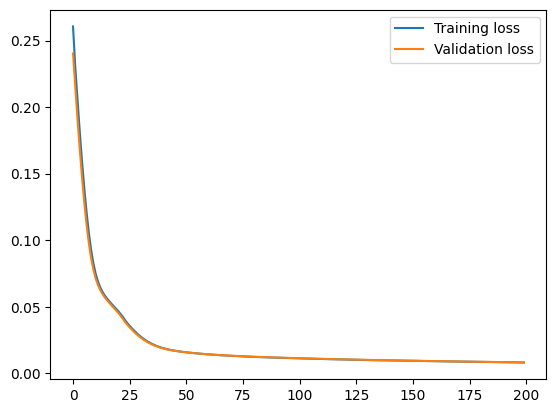

In [35]:
#Visualise the history of training
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()


**4. Testing the Hypothesis**

First, let's create the faulty dataset as we have done for test and training
1.Drop the fault label
2.Normalise based on the pipeline before

In [36]:
fault1_dataset = dataset[dataset['Fault'] == 1]
fault1_dataset=fault1_dataset.drop("Fault", axis=1)
fault_type1= fault1_dataset.values
faulty_transformeddata=pipeline.transform(fault_type1)

Calculate the mean absolute error between the reconstructions and real faulty data. We will then compare it to the mean absolute error for training and testing. The error should be at least 50% highter than that of the healthy data.

In [37]:
reconstruction_faulty =  model.predict(faulty_transformeddata)
reconstruction_loss_anomalous = np.mean(np.abs(faulty_transformeddata - reconstruction_faulty), axis=1)

344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [39]:
reconstructions = model.predict(train_transformed)
reconstruction_errors_normal_train= np.mean(np.abs(train_transformed - reconstructions), axis=1)

400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [40]:
reconstructions = model.predict(test_transformed)
reconstruction_errors_normal_test= np.mean(np.abs(test_transformed - reconstructions), axis=1)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [41]:
print(f"Average Reconstruction loss for test Data: {np.mean(reconstruction_errors_normal_test)}")
print(f"Average Reconstruction loss for train Data: {np.mean(reconstruction_errors_normal_train)}")
print(f"Average Reconstruction loss for faulty (anomalous) Data: {np.mean(reconstruction_loss_anomalous)}")

Average Reconstruction loss for test Data: 0.06403927706234881
Average Reconstruction loss for train Data: 0.0636686113716059
Average Reconstruction loss for faulty (anomalous) Data: 0.11987137639452868


In [42]:
model.save

<bound method Model.save of <Sequential name=sequential, built=True>>